In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy
import pickle
import pefile
import sklearn.ensemble as ek
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm
import threading
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\Dataset\\Obfuscated-MalMem2022\\Obfuscated-MalMem2022.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

In [4]:
#Feature Selection
features_to_drop = ['Category', 'Class']

# Droping specified columns and target variable
X = DM.drop(features_to_drop, axis=1).values    
y = DM['Class'].values

In [5]:
#Remove Nan
X = pd.DataFrame(X).dropna()
y = y[X.index]

In [6]:
# Menerapkan Min-Max scaling untuk membuat X tidak negatif
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Variance Threshold (Filter)
vt_selector = VarianceThreshold(threshold=0.001)  # Anda bisa menyesuaikan ambang batas
X_vt = vt_selector.fit_transform(X_scaled)

In [8]:
# Mendapatkan indeks fitur yang terpilih
vt_top_features = np.where(vt_selector.get_support())[0]

# Mengambil nama kolom dari X yang sudah difilter
filtered_columns = DM.drop(features_to_drop, axis=1).columns

# Mengambil nama fitur terpilih
features = []
for idx in vt_top_features:
    print(f"Feature {filtered_columns[idx]} terpilih dengan varians di atas threshold")
    features.append(filtered_columns[idx])

Feature pslist.nppid terpilih dengan varians di atas threshold
Feature pslist.avg_threads terpilih dengan varians di atas threshold
Feature dlllist.ndlls terpilih dengan varians di atas threshold
Feature dlllist.avg_dlls_per_proc terpilih dengan varians di atas threshold
Feature handles.nevent terpilih dengan varians di atas threshold
Feature handles.ndesktop terpilih dengan varians di atas threshold
Feature handles.nkey terpilih dengan varians di atas threshold
Feature handles.nthread terpilih dengan varians di atas threshold
Feature handles.ntimer terpilih dengan varians di atas threshold
Feature handles.nmutant terpilih dengan varians di atas threshold
Feature ldrmodules.not_in_load terpilih dengan varians di atas threshold
Feature ldrmodules.not_in_init terpilih dengan varians di atas threshold
Feature ldrmodules.not_in_mem terpilih dengan varians di atas threshold
Feature psxview.not_in_pslist terpilih dengan varians di atas threshold
Feature psxview.not_in_eprocess_pool terpilih 

In [9]:
# Memilih 100% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('Class').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)
hasil_threshold = []

In [10]:
def Thresholding(threshold, feature):
    # Mengukur waktu mulai
    start_time = time.time()

    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # Untuk BenignDataThreshold
    y_true_benign = ["Benign"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["Class"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["Malware"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["Class"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp / (tp + fp) if (tp + fp) != 0 else 0
    RecallThreshold = tp / (tp + fn) if (tp + fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold * RecallThreshold) / (PrecisionThreshold + RecallThreshold)) if (PrecisionThreshold + RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) != 0 else 0

    # Mengukur waktu selesai
    elapsed_time = time.time() - start_time

    # Menyimpan hasil dalam format satu baris untuk setiap threshold
    hasil_threshold.append([feature, threshold, PrecisionThreshold, RecallThreshold, F1ScoreThreshold, AccuracyThreshold, elapsed_time])

# Lakukan thresholding pada fitur yang dipilih oleh Chi-Square Test
for feature in tqdm(features, desc='Progress'):
    # Pastikan bahwa Min dan Max adalah nilai numerik
    Max = pd.to_numeric(sampled_data[feature], errors='coerce').max()
    Min = pd.to_numeric(sampled_data[feature], errors='coerce').min()

    # Cek apakah Min dan Max valid (bukan NaN)
    if pd.notna(Min) and pd.notna(Max):
        for x in range(int(Min), int(Max + 1)):
            Thresholding(x, feature)
    else:
        print(f"Fitur {feature} mengandung nilai non-numerik dan tidak dapat diproses.")

print(hasil_threshold)

# Mengubah hasil menjadi DataFrame dengan kolom yang sesuai
hasil_threshold_df = pd.DataFrame(hasil_threshold, columns=['Feature', 'Threshold', 'Precision', 'Recall', 'F1_Score', 'Accuracy', 'Elapsed_Time'])

# Simpan DataFrame ke CSV
hasil_threshold_df.to_csv('Variance Threshold.csv', index=False)

print("Hasil threshold disimpan ke dalam file 'Variance Threshold.csv'")

Progress: 100%|███████████████████████████████████████████████████████████████████████| 25/25 [56:49<00:00, 136.39s/it]


[['pslist.nppid', 8, 0.013413884906819579, 0.8811659192825112, 0.026425497579343732, 0.5058024438528227, 0.20333480834960938], ['pslist.nppid', 9, 0.019864837190251894, 0.8967642526964561, 0.03886866798009817, 0.5087889958358932, 0.16118264198303223], ['pslist.nppid', 10, 0.023892415864564136, 0.8951406649616368, 0.04654255319148936, 0.5105467950030719, 0.12165951728820801], ['pslist.nppid', 11, 0.024779848453819375, 0.6505376344086021, 0.04774117182876307, 0.5057341798074954, 0.13966035842895508], ['pslist.nppid', 12, 0.02594033722438392, 0.042998585572843, 0.03235901475315607, 0.22429858693426172, 0.20147037506103516], ['pslist.nppid', 13, 0.05362140760461465, 0.07115358485438653, 0.06115577009167527, 0.17682094340910642, 0.18031597137451172], ['pslist.nppid', 14, 0.09768584886340365, 0.11666870490399903, 0.10633673298779468, 0.17903952488224453, 0.1472482681274414], ['pslist.nppid', 15, 0.3809816369718069, 0.3363669238187078, 0.35728689862680446, 0.31466311693630966, 0.1570029258728

In [11]:
HasilThreshold = pd.read_csv("C:\\Data Raihan\\Penelitian Threshold\\02-10-2024\\Variance Threshold.csv")
HasilThreshold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19303 entries, 0 to 19302
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Feature       19303 non-null  object 
 1   Threshold     19303 non-null  int64  
 2   Precision     19303 non-null  float64
 3   Recall        19303 non-null  float64
 4   F1_Score      19303 non-null  float64
 5   Accuracy      19303 non-null  float64
 6   Elapsed_Time  19303 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.0+ MB


In [12]:
# Inisialisasi variabel winner untuk masing-masing metrik
winner_precision = ['', '', 0]  # [feature, threshold, value]
winner_recall = ['', '', 0]
winner_f1_score = ['', '', 0]
winner_accuracy = ['', '', 0]
winner_run_time = ['', '', float('inf')]  # Memilih yang terendah, jadi diinisialisasi dengan tak hingga

# Iterasi melalui setiap baris di HasilThreshold
for index, result in HasilThreshold.iterrows():
    # result['Feature'], result['Threshold'], result['Precision'], 
    # result['Recall'], result['F1_Score'], result['Accuracy'],
    # result['Elapsed_Time']
    
    # Membandingkan Precision
    if result['Precision'] > winner_precision[2]:  # result['Precision']
        winner_precision = [result['Feature'], result['Threshold'], result['Precision']]  # [feature, threshold, Precision]
    
    # Membandingkan Recall
    if result['Recall'] > winner_recall[2]:  # result['Recall']
        winner_recall = [result['Feature'], result['Threshold'], result['Recall']]  # [feature, threshold, Recall]

    # Membandingkan F1-score
    if result['F1_Score'] > winner_f1_score[2]:  # result['F1_Score']
        winner_f1_score = [result['Feature'], result['Threshold'], result['F1_Score']]  # [feature, threshold, F1 Score]

    # Membandingkan Accuracy
    if result['Accuracy'] > winner_accuracy[2]:  # result['Accuracy']
        winner_accuracy = [result['Feature'], result['Threshold'], result['Accuracy']]  # [feature, threshold, Accuracy]

    # Membandingkan waktu running (run_time) untuk threshold tercepat (terkecil)
    if result['Elapsed_Time'] < winner_run_time[2]:  # result['Elapsed_Time']
        winner_run_time = [result['Feature'], result['Threshold'], result['Elapsed_Time']]  # [feature, threshold, elapsed_time]

In [13]:
def plot_metrics_for_winner(winner, metric_name):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan kolom metrik
    thresholds = winner_results['Threshold'].tolist()  # Threshold
    precision = winner_results['Precision'].tolist()   # Precision
    recall = winner_results['Recall'].tolist()         # Recall
    f1_score = winner_results['F1_Score'].tolist()     # F1 Score
    accuracy = winner_results['Accuracy'].tolist()      # Accuracy

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracy, label='Accuracy', marker='o')
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='o')
    plt.plot(thresholds, f1_score, label='F1 Score', marker='o')

    plt.title(f'{metric_name} Winner: Metrics vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def plot_runtime_for_winner(winner):
    winner_feature, winner_threshold = winner[0], winner[1]

    # Memfilter hasil threshold untuk fitur pemenang
    winner_results = HasilThreshold[HasilThreshold['Feature'] == winner_feature]

    # Pisahkan hasil menjadi list berdasarkan threshold dan run_time
    thresholds = winner_results['Threshold'].tolist()    # Threshold
    run_time = winner_results['Elapsed_Time'].tolist()   # Run Time (elapsed_time)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, run_time, label='Run Time', marker='o')

    plt.title(f'Run Time Winner: Run Time vs. Threshold for Feature {winner_feature}')
    plt.xlabel('Threshold')
    plt.ylabel('Run Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.show()

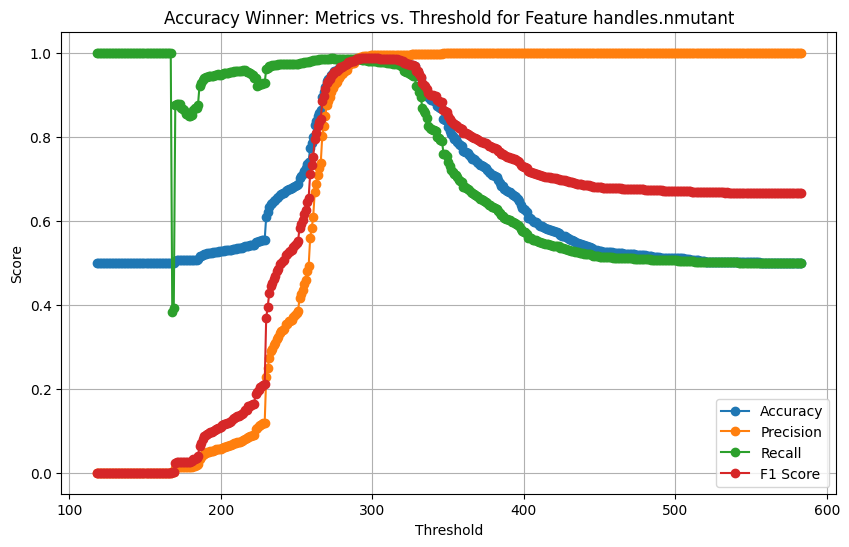

In [15]:
# Plot untuk Accuracy Winner
plot_metrics_for_winner(winner_accuracy, 'Accuracy')

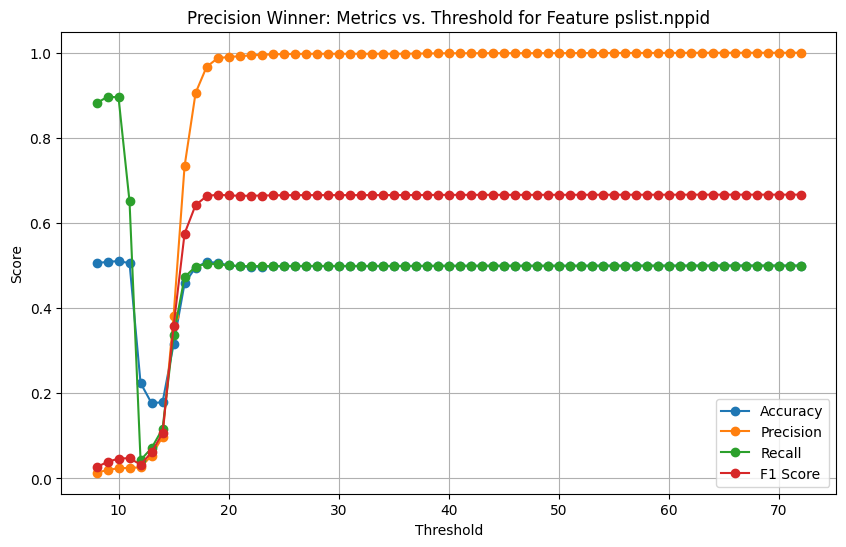

In [16]:
# Plot untuk Precision Winner
plot_metrics_for_winner(winner_precision, 'Precision')

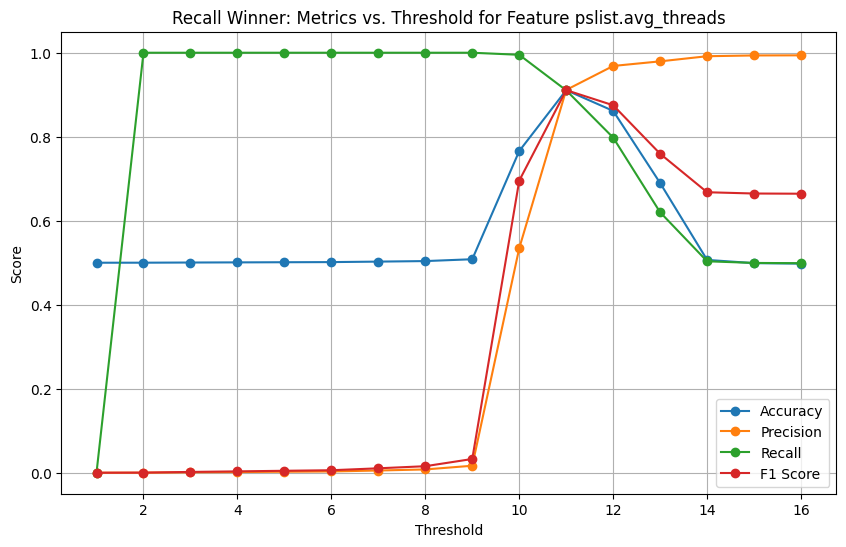

In [17]:
# Plot untuk Recall Winner
plot_metrics_for_winner(winner_recall, 'Recall')

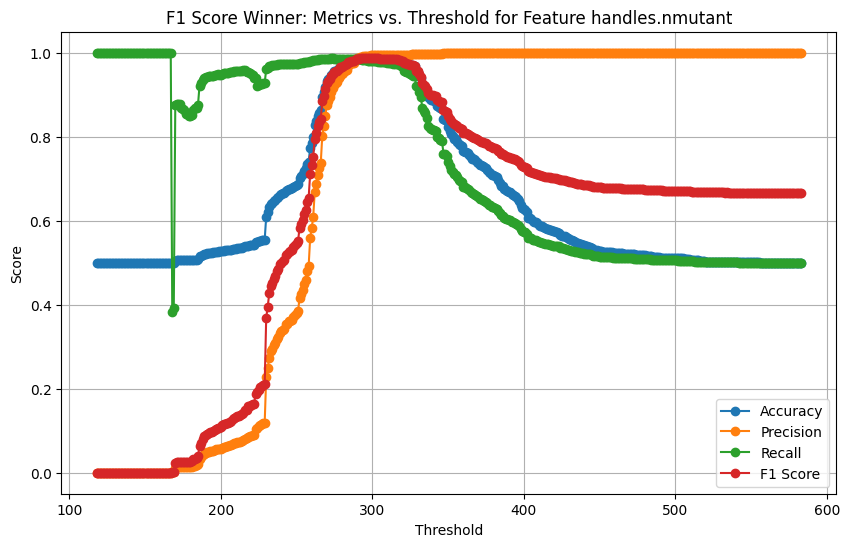

In [18]:
# Plot untuk F1-Score Winner
plot_metrics_for_winner(winner_f1_score, 'F1 Score')

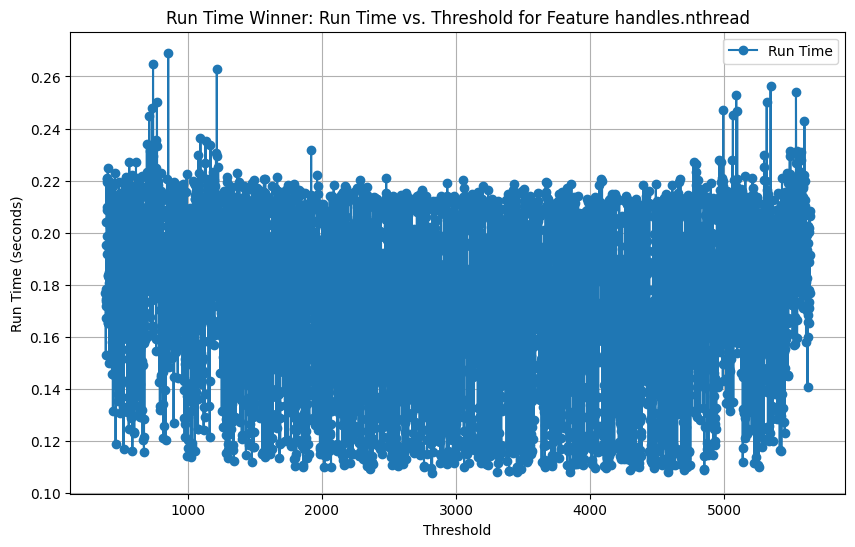

In [19]:
# Plot untuk Run Time Winner
plot_runtime_for_winner(winner_run_time)

In [20]:
# Output untuk setiap metrik
print(f"Precision terbaik dicapai dengan fitur {winner_precision[0]} dan threshold {winner_precision[1]}, menghasilkan precision {winner_precision[2]}.")
print(f"Recall terbaik dicapai dengan fitur {winner_recall[0]} dan threshold {winner_recall[1]}, menghasilkan recall {winner_recall[2]}.")
print(f"F1-score terbaik dicapai dengan fitur {winner_f1_score[0]} dan threshold {winner_f1_score[1]}, menghasilkan F1-score {winner_f1_score[2]}.")
print(f"Akurasi terbaik dicapai dengan fitur {winner_accuracy[0]} dan threshold {winner_accuracy[1]}, menghasilkan akurasi {winner_accuracy[2]}.")
print(f"Waktu running tercepat dicapai dengan fitur {winner_run_time[0]} dan threshold {winner_run_time[1]}, dengan waktu running {winner_run_time[2]} detik.")

Precision terbaik dicapai dengan fitur pslist.nppid dan threshold 72, menghasilkan precision 1.0.
Recall terbaik dicapai dengan fitur pslist.avg_threads dan threshold 2, menghasilkan recall 1.0.
F1-score terbaik dicapai dengan fitur handles.nmutant dan threshold 295, menghasilkan F1-score 0.9877184936044436.
Akurasi terbaik dicapai dengan fitur handles.nmutant dan threshold 295, menghasilkan akurasi 0.9876612738070858.
Waktu running tercepat dicapai dengan fitur handles.nthread dan threshold 2822, dengan waktu running 0.1078863143920898 detik.
